In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 3

# Quantile Analysis
Another form of non-linear analysis is the analysis of the simulated **performance of stocks grouped** based on the information signal.

Alpha models based on factors (value, momentum, profitability, low-risk) normally have a **relative bet structure**: based on the signal we divide stocks into groups (good vs bad, or good vs meh vs bad, or very good vs good vs meh vs...). We are not forecasting that it stock ABC will go up, but that will perform better than stock XYZ. 

A natural way to test the quality of an information signal is simply to:
1. **Rank** stocks based on the signal.
1. **Divide** them into groups.
1. **Measure** the future return of said groups.

___
## 1. Data
Let's start by loading our data on prices and an information signal, and create the future returns  that we can match with the information signal. We will follow the usual procedure

$$ r_{t,t+1} = \log \left(\frac{P_{t+1}}{P_{t}}\right)$$

In [31]:
# we load the prices and calculate the future returns
prices = pd.read_csv('Prices.zip', parse_dates=['date']).set_index(['id', 'date'])
future_returns = np.log(prices['price'].groupby('id').shift(-1) / prices['price']).rename('fut_ret')

# we load the information signal. To make our code more general we are going to rename the information signal
signal = pd.read_csv('EPQ.zip', parse_dates=['date']).set_index(['id', 'date'])

# we merge signal and future returns in the same DataFrame
data = signal.join(future_returns).dropna()
data.head()

epq   fut_ret
id    date                          
10001 1986-11-28 -0.042374  0.014889
      1986-12-31 -0.029329 -0.036367
      1987-01-30 -0.060923 -0.076961
      1987-02-27  0.209550  0.036139
      1987-03-31  0.171018 -0.040006

___
## 2. Forming the Groups
We can now start our quantile analysis by grouping the stocks based on the information signal. To achieve this we can use the pandas function **[`pandas.qcut()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html)**. Please notice that is the **[`pandas.GroubBy()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)** operator we are using a new parameter `group_keys=False`, this is to avoid having the grouping keys added as an additional index level in our result.

In [32]:
# We start by choosing the number of bins
N = 4

# We apply the pandas.qcut() function using a lambda function
data['group'] = data.groupby('date', group_keys=False)['epq'].apply(lambda x: pd.qcut(x,N, labels=False))

data.head()

epq   fut_ret  group
id    date                                 
10001 1986-11-28 -0.042374  0.014889      0
      1986-12-31 -0.029329 -0.036367      0
      1987-01-30 -0.060923 -0.076961      0
      1987-02-27  0.209550  0.036139      3
      1987-03-31  0.171018 -0.040006      3

Has the function worked? Let's count how many observations we have in any bin. We can easily do this with the method [**`Series.value_counts()`**](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) that simply counts the values of a variable. If we look at the values of the new column we see...

In [33]:
data['group'].value_counts().sort_index() #The sort index is to have the value ranked based on the bin number, the index.

group
0    569460
1    564534
2    566435
3    566482
Name: count, dtype: int64

...that, in fact, the sample is more or less **equally split between the different groups**. If you are ocd like me and hate to see the group numbering starting from zero, you can apply **add 1 at the end**.

In [34]:
data['group'] = data.groupby('date', group_keys=False)['epq'].apply(lambda x: pd.qcut(x,N, labels=False))+1
data['group'].value_counts().sort_index()

group
1    569460
2    564534
3    566435
4    566482
Name: count, dtype: int64

We can now calculate the average signal, and the **average future return** for the stocks in each group:

In [35]:
portfolios = data.groupby(['date','group']).mean()
portfolios.head(10)

epq   fut_ret
date       group                    
1980-01-31 1     -0.755915 -0.021712
           2     -0.031198 -0.029601
           3      0.178221 -0.041588
           4      0.623994 -0.035921
1980-02-29 1     -0.754740 -0.223704
           2     -0.021960 -0.165179
           3      0.174859 -0.154342
           4      0.597305 -0.152516
1980-03-31 1     -0.551366  0.039173
           2      0.007399  0.053550

Since we have grouped by 2 variables (`date` and `group`) the output is a DateFrame with a double index: each individual observation is identified by a combination of a specific date and a specific group. This is called a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) and it's a very powerful tool in Pandas. We can [**`DataFrame.unstack()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html) the groups to have the return of each group in a different column:

In [36]:
port_returns = portfolios['fut_ret'].unstack(level=1) #level 0 is the first index (date), level 1 is the second (group).
port_returns.head()

group,1,2,3,4
date,,,,
1980-01-31,-0.021712,-0.029601,-0.041588,-0.035921
1980-02-29,-0.223704,-0.165179,-0.154342,-0.152516
1980-03-31,0.039173,0.053550,0.057407,0.057005
1980-04-30,0.060364,0.062867,0.075365,0.078192
1980-05-30,0.029738,0.032223,0.028505,0.047092


___
## 3. Measuring the Performance
Now we have easy to use time series for the monthly return of each portfolio. At this point we can start measuring their performance:

In [37]:
# annualized mean return
port_returns.mean()*12

group
1   -0.267502
2   -0.051467
3    0.065590
4    0.114663
dtype: float64

In [38]:
# annualized volatility
port_returns.std()*np.sqrt(12)

group
1    0.297490
2    0.212798
3    0.169228
4    0.189973
dtype: float64

In [39]:
# annualized Return/Risk Ration, a simplified version of the Sharpe ratio without risk-free fate
(port_returns.mean()*12) / port_returns.std()*np.sqrt(12)

group
1   -10.790354
2    -2.902325
3     4.650970
4     7.242898
dtype: float64

We can see that the information signal performs well: **higher groups have higher average return**. Instead of printing these performance measures on screen, we can **store them in a DataFrame.**

In [40]:
mean_return = port_returns.mean()*12
volatility = port_returns.std()*np.sqrt(12)
rr_ratio = (port_returns.mean()*12) / port_returns.std()*np.sqrt(12)

performance = pd.DataFrame({'Mean Ret': mean_return,
                            'Std Dev': volatility,
                            'RR Ratio': rr_ratio})
performance

,Mean Ret,Std Dev,RR Ratio
group,,,
1,-0.267502,0.297490,-10.790354
2,-0.051467,0.212798,-2.902325
3,0.065590,0.169228,4.650970
4,0.114663,0.189973,7.242898


### 3.1 Plotting Performance
We can also plot the performance of each portfolio. To do this, we need to convert monthly returns into a series of portfolio prices. Since we are using logarithmic returns this is trivial. We know that if an asset has, in three periods, returns equal to $r_{1}$, $r_{2}$ and $r_{3}$, than the return from time 0 to time 3 is simply the sum
$$r_{0, 3} = \sum_{t=1}^{3}r_{t}$$

And we also know that the dollar value at the end of time 3 of a $1 investment in time 0 is

$$W_{3} = \$1\times e^{r_{0, 3}}$$

We can simply apply the Numpy exponential function [**`numpy.exp()`**](https://numpy.org/doc/stable/reference/generated/numpy.exp.html) to the cumulative returns calculated using the [**`DataFrame.cumsum()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) method. 


In [ ]:
port_values = port_returns.cumsum().apply(np.exp)
port_values.head()

                   1         2          3           4  Benchmark      Active  \
date                                                                           
1980-01-31  0.978522  0.970833   0.959265    0.964717   0.968311    0.996288   
1980-02-29  0.782379  0.823016   0.822070    0.828253   0.813703    1.017881   
1980-03-31  0.813635  0.868289   0.870643    0.876839   0.856950    1.023209   
1980-04-30  0.864262  0.924628   0.938795    0.948153   0.918345    1.032458   
1980-05-30  0.890350  0.954908   0.965940    0.993871   0.950477    1.045655   
...              ...       ...        ...         ...        ...         ...   
2024-07-31  0.000007  0.100407  18.969570  170.853867   0.215752  791.898751   
2024-08-30  0.000007  0.099510  19.176042  171.374633   0.212589  806.129508   
2024-09-30  0.000006  0.098070  18.759305  170.293440   0.208281  817.614799   
2024-10-31  0.000006  0.105010  20.346308  184.960485   0.221037  836.785264   
2024-11-29  0.000006  0.099088  19.03096

,1,2,3,4,Benchmark,Active,Neutral,year
date,,,,,,,,
1980-01-31,0.978522,0.970833,0.959265,0.964717,0.968311,0.996288,0.985891,inf
1980-02-29,0.782379,0.823016,0.822070,0.828253,0.813703,1.017881,1.058633,inf
1980-03-31,0.813635,0.868289,0.870643,0.876839,0.856950,1.023209,1.077681,inf
1980-04-30,0.864262,0.924628,0.938795,0.948153,0.918345,1.032458,1.097066,inf
1980-05-30,0.890350,0.954908,0.965940,0.993871,0.950477,1.045655,1.116270,inf


And then we can easily **plot them**.

<Axes: title={'center': 'Quantile Portfolio Values'}, xlabel='Time', ylabel='Portfolio Value'>

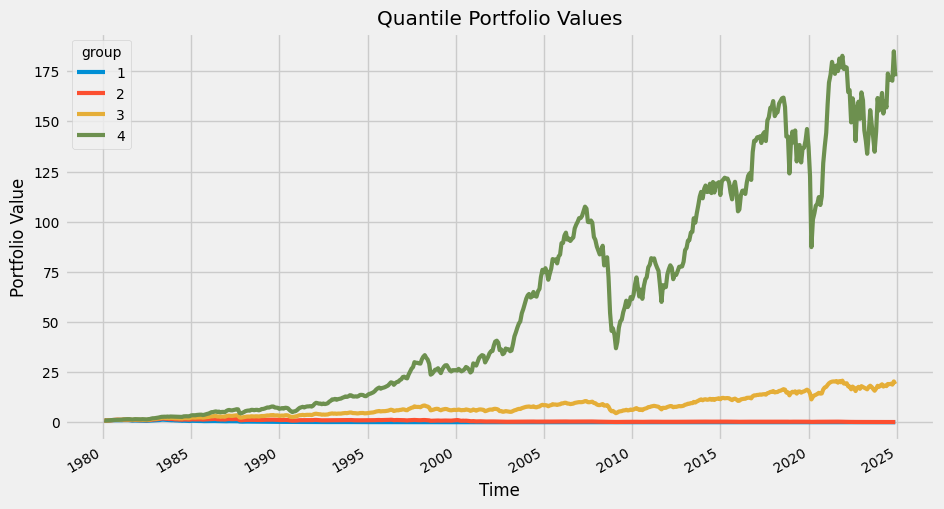

In [42]:
port_values.plot(figsize=(10,6),
                 title='Quantile Portfolio Values',
                 xlabel='Time',
                 ylabel='Portfolio Value')

Visual inspection of the graph confirms that **the information signal has value**: higher signal leads to higher average performance. This is no surprise given the higher average monthly return, but when you present your strategy to possible investors, **a graph is worth 10 tables**...

This graph is not very easy to read. The last quintile portfolio has a very strong performance that, on a linear scale, makes the performance of the other portfolios difficult to read. To be able to compare the returns graphically we need to plot the portfolio values on a **logarithmic scale**.

<Axes: title={'center': 'Quantile Portfolio Values'}, xlabel='Time', ylabel='Portfolio Value (Log-Scale)'>

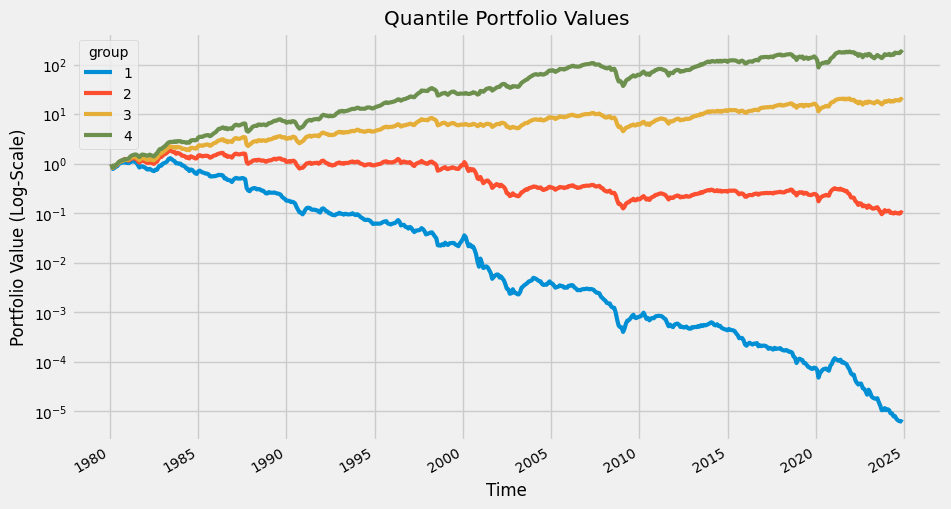

In [43]:
port_values.plot(figsize=(10,6),
                 title='Quantile Portfolio Values',
                 xlabel='Time',
                 ylabel='Portfolio Value (Log-Scale)',
                 logy=True) #the last argument specifies log-scale for the Y axis

Now we clearly see that the ranking of the portfolio performance is as expected: the lower the information signal, the worse is the performance.

___
### Exercise 8.01
Let's now assess the quality of another commonly used investment strategy: low-volatility. In this case want to invest in low-risk (low beta) stocks. 

**STEP 1:** Load the data in `N_BETA.zip` into a DataFrame called `new_signal`. Show the first few lines. Please notice that this is a "normalized beta". This means that the number has been transformed so the higher the value, **the lower is the actual beta** of the company, and the better is the stock based on a traditional low-volatility strategy. 

In [60]:
new_signal = pd.read_csv('N_BETA.zip', parse_dates=['date']).set_index(['id', 'date'])
new_signal.head()

n_beta
id    date                
10001 1996-07-31 -0.003659
      1996-08-30 -0.005802
      1996-09-30 -0.010779
      1996-10-31 -0.010635
      1996-11-29 -0.014119

**STEP 2:** Combine `new_signal` with `future_returns` into a DataFrame called `new_data`:

In [61]:
new_data = new_signal.join(future_returns).dropna()
new_data.head()

n_beta   fut_ret
id    date                          
10001 1996-07-31 -0.003659  0.037458
      1996-08-30 -0.005802  0.040916
      1996-09-30 -0.010779 -0.028987
      1996-10-31 -0.010635  0.028988
      1996-11-29 -0.014119 -0.061268

**STEP 3:** Using a lambda function and the `pandas.qcut()` function, add a new column called `group` to the DataFrame `new_data` where you split the stocks **into 3 groups** based on the value of the `n_beta` column. Fix the function so that the groups are numbered `1, 2, 3` instead of `0, 1, 2`.

In [ ]:
new_data['group'] = new_data.groupby('date', group_keys=False)['n_beta'].apply(lambda x: pd.qcut(x, N, labels=False))+1
new_data.head()

n_beta   fut_ret  group
id    date                                 
93436 2023-08-31 -1.631775 -0.030929      1
      2023-09-29 -1.627201 -0.219832      1
      2023-10-31 -1.652103  0.178463      1
      2023-11-30 -1.656419  0.034390      1
      2023-12-29 -1.647187 -0.282704      1

**STEP 4:** Create a new DataFrame called `new_portfolios` the average return, in each month, of the stocks in the three groups. Using the `df.unstack()` method put the monthly return of each of the three groups in a separate column.

In [68]:
new_portfolios = new_data.groupby(['date', 'group']).mean().unstack(1)
new_portfolios.head()

n_beta                                 fut_ret            \
group              1         2         3         4         1         2   
date                                                                     
1979-01-31 -1.788357 -1.352564 -1.084965 -0.747564 -0.053911 -0.029009   
1979-02-28 -1.786304 -1.350478 -1.083271 -0.747585  0.111172  0.081592   
1979-03-30 -1.789872 -1.350996 -1.083364 -0.746327  0.023125  0.020427   
1979-04-30 -1.790349 -1.353709 -1.084510 -0.746432 -0.016850 -0.014850   
1979-05-31 -1.790944 -1.353650 -1.085867 -0.747301  0.056425  0.049990   

                                
group              3         4  
date                            
1979-01-31 -0.027169 -0.008491  
1979-02-28  0.075988  0.044424  
1979-03-30  0.019804  0.007588  
1979-04-30 -0.014826 -0.005195  
1979-05-31  0.045434  0.050340

**STEP 5:** Create a new DataFrame called `new_port_values` with the value, at the end of each month, of $1 invested in each of the three portfolio at the beginning of our investment period. Plot the portfolios using a semi-logarithmic plot. 

<Axes: title={'center': 'Quintile Beta groups'}, xlabel='time', ylabel='Portfolio Value (log-scale)'>

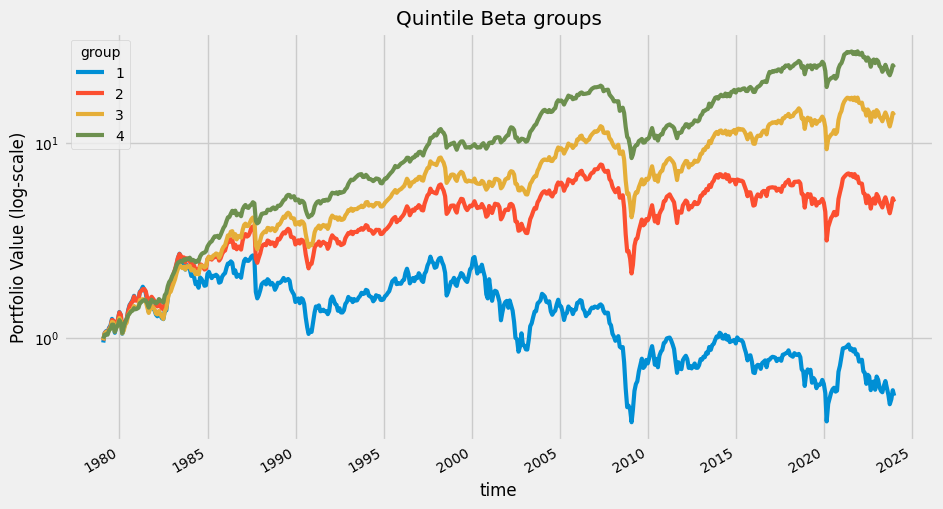

In [70]:
new_port_values = new_portfolios['fut_ret'].cumsum().apply(np.exp)
new_port_values.head()

new_port_values.plot(figsize=(10, 6),
                     title='Quintile Beta groups',
                     xlabel='time',
                     ylabel='Portfolio Value (log-scale)',
                     logy=True)


___
## 4. Zero-Investment Portfolios
So far we have analyzed the performance of an hypothetical portfolio strategy of the type _"Invest in Group 4"_ or _"Invest in Group N"_. Even if our signal is very good, such a **long-only strategy** could still experience significant losses if the market as a whole falls. The performance of our portfolios **during the GFC** is an example of this.

The reason for this apparent "bug" in our approach, is that our alpha model produces **relative bets**, so we should **invest accordingly**. We do not know that group N will _perform "well"_, we know that it will likely perform _"better than group 1"_, or _"better than the market"_ (the two bets are equivalent: the market is made of group 1, 2, ..., N).

We can simulate the performance of two different **zero-investment strategies**:
* We go long in the "best" group and short on the "worst" group.
* We go long in the "best" group and short on the market.

These strategies are called zero-investment because in an ideal world we could **use the proceeds** from the short positions to finance the investment in the long positions. This is not really the case, as the market regulators normally require **margin deposits** to guarantee the short positions.

Since this is not a realistic backtesting but we are simply doing some non-linear statistical analysis let's start by using the **average return of all the stocks** as a proxy for the market return:

In [44]:
benchmark_return = data.groupby('date')['fut_ret'].mean().rename('Benchmark')
benchmark_return.head()

date
1980-01-31   -0.032202
1980-02-29   -0.173957
1980-03-31    0.051784
1980-04-30    0.069194
1980-05-30    0.034391
Name: Benchmark, dtype: float64

Let's merge this into the `port_returns` DataFrame

In [45]:
port_returns = port_returns.join(benchmark_return.to_frame())
port_returns.head()

,1,2,3,4,Benchmark
date,,,,,
1980-01-31,-0.021712,-0.029601,-0.041588,-0.035921,-0.032202
1980-02-29,-0.223704,-0.165179,-0.154342,-0.152516,-0.173957
1980-03-31,0.039173,0.053550,0.057407,0.057005,0.051784
1980-04-30,0.060364,0.062867,0.075365,0.078192,0.069194
1980-05-30,0.029738,0.032223,0.028505,0.047092,0.034391


Let's now create a zero-investment strategy called `Active` where we go long on the best portfolio and short on the market. In the same way we can create a second zero-investment strategy called `Neutral` where we go long on the best group and short on the worst:

In [46]:
port_returns['Active'] = port_returns[N] - port_returns['Benchmark']
port_returns['Neutral'] = port_returns[N] - port_returns[1]
port_returns.head()

,1,2,3,4,Benchmark,Active,Neutral
date,,,,,,,
1980-01-31,-0.021712,-0.029601,-0.041588,-0.035921,-0.032202,-0.003719,-0.014209
1980-02-29,-0.223704,-0.165179,-0.154342,-0.152516,-0.173957,0.021441,0.071188
1980-03-31,0.039173,0.053550,0.057407,0.057005,0.051784,0.005221,0.017832
1980-04-30,0.060364,0.062867,0.075365,0.078192,0.069194,0.008998,0.017828
1980-05-30,0.029738,0.032223,0.028505,0.047092,0.034391,0.012701,0.017354


In [47]:
mean_return = port_returns.mean()*12
volatility = port_returns.std()*np.sqrt(12)
rr_ratio = (port_returns.mean()*12) / (port_returns.std()*np.sqrt(12))

performance = pd.DataFrame({'Mean Return': mean_return,
                            'St. Dev.': volatility,
                            'RR_ratio': rr_ratio})

performance

,Mean Return,St. Dev.,RR_ratio
1,-0.267502,0.297490,-0.899196
2,-0.051467,0.212798,-0.241860
3,0.065590,0.169228,0.387581
4,0.114663,0.189973,0.603575
Benchmark,-0.034982,0.207297,-0.168755
Active,0.149645,0.068063,2.198621
Neutral,0.382165,0.178197,2.144620


We see that both zero-investment strategies yield a good performance. Let's plot them:

In [48]:
port_values = port_returns.cumsum().apply(np.exp)
port_values.head()

,1,2,3,4,Benchmark,Active,Neutral
date,,,,,,,
1980-01-31,0.978522,0.970833,0.959265,0.964717,0.968311,0.996288,0.985891
1980-02-29,0.782379,0.823016,0.822070,0.828253,0.813703,1.017881,1.058633
1980-03-31,0.813635,0.868289,0.870643,0.876839,0.856950,1.023209,1.077681
1980-04-30,0.864262,0.924628,0.938795,0.948153,0.918345,1.032458,1.097066
1980-05-30,0.890350,0.954908,0.965940,0.993871,0.950477,1.045655,1.116270


<Axes: title={'center': 'Zero-Investment Portfolio Value'}, xlabel='Time', ylabel='Portfolio Value (Log-Scale)'>

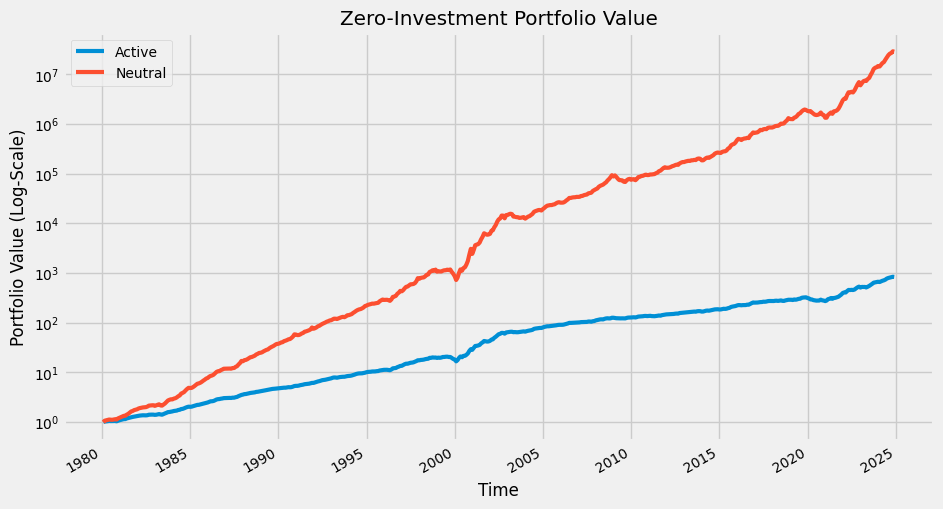

In [49]:
port_values[['Active', 'Neutral']].plot(figsize=(10,6),
                                        title='Zero-Investment Portfolio Value',
                                        xlabel='Time',
                                        ylabel='Portfolio Value (Log-Scale)',
                                        logy=True)

Now we see that our alpha model performs well also during the GFC: **the relative bet still yields a positve performance** in that period.

### 4.1. Period analysis
The fact that our signal has predictive power, on average, between 1980 and 2020 is relevant, but we may be interested to observe the performance in **different periods of time**. 

In [50]:
# we extract the year from the index of the DataFrame
port_returns['year'] = port_returns.index.year
port_returns.head()

,1,2,3,4,Benchmark,Active,Neutral,year
date,,,,,,,,
1980-01-31,-0.021712,-0.029601,-0.041588,-0.035921,-0.032202,-0.003719,-0.014209,1980
1980-02-29,-0.223704,-0.165179,-0.154342,-0.152516,-0.173957,0.021441,0.071188,1980
1980-03-31,0.039173,0.053550,0.057407,0.057005,0.051784,0.005221,0.017832,1980
1980-04-30,0.060364,0.062867,0.075365,0.078192,0.069194,0.008998,0.017828,1980
1980-05-30,0.029738,0.032223,0.028505,0.047092,0.034391,0.012701,0.017354,1980


<Axes: title={'center': 'Active Return (Top - Bottom)'}, xlabel='Year', ylabel='Annualized Mean Monthly Return'>

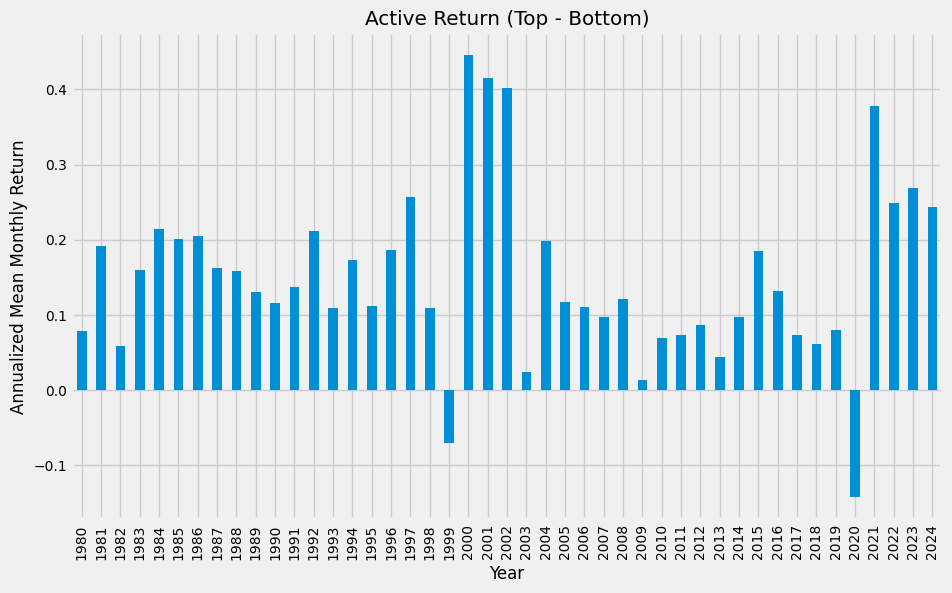

In [51]:
# we can recalculate all our diagnostics by year, for example:
mean_active = port_returns.groupby('year')['Active'].mean()*12
mean_active.plot(figsize=(10,6),
                 kind='bar',
                 title='Active Return (Top - Bottom)',
                 xlabel='Year',
                 ylabel='Annualized Mean Monthly Return')

And we see that our information signal has predictive power more or less **constantly across our sample**. We also observe that the model **failed during the GFC**. Period analysis can provide many insights, for example we could find out that our signal has not worked well in the last few years...

___
## 5. In Production
As usual, now that we understand the nature of this analysis we want to encapsulate all the relevant code in an easy-to-use function.

In [52]:
#Let's also create a function with the calculation of the performance measures given the return of our portfolios

def diagnostics(port_returns):
    
    mean_return = port_returns.mean()*12
    volatility = port_returns.std()*np.sqrt(12)
    rr_ratio = (port_returns.mean()*12) / (port_returns.std()*np.sqrt(12))

    performance = pd.DataFrame({'Mean Ret': mean_return,
                                'Std Dev': volatility,
                                'RR Ratio': rr_ratio})
    
    return performance


# Let's now create the main function that runs the quantile analysis. At the end this function will call the diagnostic 
# function and create the table with the performance measures. Notice that this function returns two outputs

def quantile_analysis(signal, prices, n_bins=4):
    
    #We capture the name of the factor using the .name attribute to use it later
    signal_name = signal.name
    
    #We calculate the future returns
    future_returns = np.log(prices.groupby('id').shift(-1) / prices).rename('fut_ret')
    
    #We join the signal with the future returns
    data = signal.to_frame().join(future_returns).dropna()
    
    #We apply the pandas.qcut() function using a lambda function
    data['group'] = data.groupby('date', group_keys=False)[signal_name].apply(lambda x: pd.qcut(x,n_bins, labels=False))+1
    
    #We calculate the average return of the groups
    portfolios = data.groupby(['date','group']).mean()
    
    #We rearrange the results in order to have one group per column
    port_returns = portfolios['fut_ret'].unstack(level=1) 
    
    #We calculate the benchmark return
    benchmark_return = data.groupby('date')['fut_ret'].mean().rename('Benchmark')
    port_returns = port_returns.join(benchmark_return.to_frame())
    
    #We calculate the return of the zero-investment portfolios
    port_returns['Active'] = port_returns[n_bins] - port_returns['Benchmark']
    port_returns['Neutral'] = port_returns[n_bins] - port_returns[1]
    
    performance = diagnostics(port_returns)
    
    return port_returns, performance

And now, if we want to run the analysis again **using 5 quintiles**, we can do everything with two simple lines of code:

In [53]:
return_5, performance_5 = quantile_analysis(signal['epq'], prices['price'], n_bins = 5)

return_5.head()

,1,2,3,4,5,Benchmark,Active,Neutral
date,,,,,,,,
1980-01-31,-0.018808,-0.028880,-0.034022,-0.045162,-0.034195,-0.032202,-0.001993,-0.015388
1980-02-29,-0.234592,-0.173983,-0.152284,-0.152521,-0.156358,-0.173957,0.017599,0.078234
1980-03-31,0.036064,0.050457,0.062779,0.053777,0.055842,0.051784,0.004058,0.019778
1980-04-30,0.056513,0.066598,0.066340,0.075309,0.081212,0.069194,0.012018,0.024699
1980-05-30,0.029339,0.030579,0.031676,0.033255,0.047089,0.034391,0.012698,0.017750


In [54]:
performance_5

,Mean Ret,Std Dev,RR Ratio
1,-0.293797,0.310840,-0.945170
2,-0.105441,0.235298,-0.448118
3,0.024447,0.180960,0.135098
4,0.081386,0.168161,0.483977
5,0.119227,0.195774,0.609001
Benchmark,-0.034982,0.207297,-0.168755
Active,0.154209,0.067575,2.282033
Neutral,0.413024,0.188640,2.189485


___
### Important Coding Note
Quantile analysis is one of the tools that we will **need again, and again** in our subject. So the `quantile_analysis()` function has been stored in our `apmodule`. When you will need to perform this analysis in the coding exercises and the assignment, you will not need to copy/paste the function, but you will simply **import the module** and use the function from there:

In [55]:
import apmodule as ap
ret_5, perf_5 = ap.quantile_analysis(signal['epq'], prices['price'], n_bins = 5)

In [56]:
ret_5.head()

,1,2,3,4,5,Benchmark,Active,Neutral
date,,,,,,,,
1980-01-31,-0.018808,-0.028880,-0.034022,-0.045162,-0.034195,-0.032202,-0.001993,-0.015388
1980-02-29,-0.234592,-0.173983,-0.152284,-0.152521,-0.156358,-0.173957,0.017599,0.078234
1980-03-31,0.036064,0.050457,0.062779,0.053777,0.055842,0.051784,0.004058,0.019778
1980-04-30,0.056513,0.066598,0.066340,0.075309,0.081212,0.069194,0.012018,0.024699
1980-05-30,0.029339,0.030579,0.031676,0.033255,0.047089,0.034391,0.012698,0.017750


Please notice that the `diagnostics()` function in the `apmodule` is slightly more advanced than the one written in this notebook. Beside showing the results **transposed** with the different portfolios in each column and different measures in each row, it also provides few **non-parametric measures of risk**. These will be introduced next week, but most of them are quite intuitive. The only one that you may not be familiar with is the [Maximum Drawdown](https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp). 

In [57]:
perf_5

,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.293797,-0.105441,0.024447,0.081386,0.119227,-0.034982,0.154209,0.413024
St. Dev.,0.310840,0.235298,0.180960,0.168161,0.195774,0.207297,0.067575,0.188640
RR Ratio,-0.945170,-0.448118,0.135098,0.483977,0.609001,-0.168755,2.282033,2.189485
% Positive,0.378479,0.497217,0.578850,0.623377,0.641929,0.525046,0.821892,0.807050
Worst Month,-0.415484,-0.385857,-0.355660,-0.330867,-0.357436,-0.363357,-0.085611,-0.258639
Best Month,0.414635,0.189300,0.146458,0.126137,0.174223,0.173900,0.115471,0.315419
Max DrawDown,-1.523281,-1.079329,-0.708889,-0.710704,-0.903422,-0.929931,-0.210776,-0.483401


___
### Exercise 8.02
When it comes to low-volatility strategy, we can measure the risk of each stock in different ways:
* Total Risk: Total Volatility (`TVOL.zip`)
* Systematic Risk: Beta (`N_BETA.zip`)
* Idiosyncratic Risk: Idiosyncratic Volatility (`IVOL.zip`)

Let's now assess the predictive power of these three different risk measures. 

**STEP 1:** Load the data in of `TVOL.zip`, `IVOL.zip` `N_BETA.zip` into three different Series

In [77]:
ivol_series = pd.read_csv('IVOL.zip', parse_dates=['date']).set_index(['date', 'id'])
tvol_series = pd.read_csv('TVOL.zip', parse_dates=['date']).set_index(['date', 'id'])
nbeta_series = pd.read_csv('N_BETA.zip', parse_dates=['date']).set_index(['date', 'id'])

nbeta_series.head()

,,n_beta
date,id,
1996-07-31,10001,-0.003659
1996-08-30,10001,-0.005802
1996-09-30,10001,-0.010779
1996-10-31,10001,-0.010635
1996-11-29,10001,-0.014119


**STEP 2:** Use the `quantile_analysis()` from the `apmodule` to perform a quintile analysis (`n_bins=5`) for the three measures. Print on screen the table with the diagnostics for each measure. 

In [85]:
ret_ivol_5, perf_ivol_5 = ap.quantile_analysis(ivol_series['ivol'], prices['price'], 5)
ret_tvol_5, perf_tvol_5 = ap.quantile_analysis(tvol_series['tvol'], prices['price'], 5)
ret_nbeta_5, perf_nbeta_5 = ap.quantile_analysis(nbeta_series['n_beta'], prices['price'], 5)

print(perf_ivol_5)
print(perf_tvol_5)
print(perf_nbeta_5)

ret_ivol_5.head()

                     1         2         3         4         5  Benchmark  \
Mean Return  -0.094109  0.028291  0.064903  0.088724  0.099524   0.037444   
St. Dev.      0.255825  0.213108  0.191043  0.172824  0.130674   0.182746   
RR Ratio     -0.367865  0.132754  0.339732  0.513382  0.761619   0.204895   
% Positive    0.477778  0.568519  0.592593  0.629630  0.659259   0.577778   
Worst Month  -0.402252 -0.355723 -0.337995 -0.307900 -0.192665  -0.319344   
Best Month    0.273760  0.205519  0.210936  0.176656  0.108208   0.174377   
Max DrawDown -1.007675 -0.975646 -0.972616 -0.853719 -0.623800  -0.886684   

                Active   Neutral  
Mean Return   0.062080  0.193633  
St. Dev.      0.093402  0.198404  
RR Ratio      0.664657  0.975955  
% Positive    0.592593  0.642593  
Worst Month  -0.115980 -0.277892  
Best Month    0.126678  0.249199  
Max DrawDown -0.307051 -0.624293  
                     1         2         3         4         5  Benchmark  \
Mean Return  -0.093343  0.

,1,2,3,4,5,Benchmark,Active,Neutral
date,,,,,,,,
1979-01-31,-0.031568,-0.024060,-0.033732,-0.035979,-0.022901,-0.029645,0.006744,0.008668
1979-02-28,0.097994,0.105886,0.075492,0.076906,0.035311,0.078318,-0.043007,-0.062683
1979-03-30,0.033562,0.021332,0.022133,0.015182,-0.003510,0.017736,-0.021246,-0.037072
1979-04-30,-0.017478,-0.009049,-0.021509,-0.015472,-0.001128,-0.012930,0.011802,0.016349
1979-05-31,0.055651,0.054663,0.045276,0.056269,0.040858,0.050547,-0.009689,-0.014793


**STEP 3:** Comparing the three measures across three different diagnostic tables is quite confusing. We also have so many performance measures. To simplify our task, let's **focus on the "Active Performance"** of each strategy. Can you extract, from each of the three diagnostic table, the column `Active`. This will become a series. You can then join the three series together into a new smaller diagnostic table called `perf_active`. Remember to rename the series with the name of the risk measure, otherwise they will all appear as `Active`...

In [84]:
perf_active = pd.DataFrame({'tvol' : perf_tvol_5['Active'],
                            'ivol' : perf_ivol_5['Active'],
                            'n_beta' : perf_nbeta_5['Active']})

perf_active.head()

,tvol,ivol,n_beta
Mean Return,0.062581,0.062080,0.034871
St. Dev.,0.096477,0.093402,0.084367
RR Ratio,0.648661,0.664657,0.413319
% Positive,0.588889,0.592593,0.533333
Worst Month,-0.114884,-0.115980,-0.096375


**STEP 4:** The `quantile_analysis()` function returns, in the first output, the monthly return of the different quantile portfolios, as well as the active (`Best - Benchmark`) and neutral (`Best - Worst`) zero investment strategies. Extract the column `Active` from each DataFrame and combine them into a single DataFrame called `ret_active` (as before, you should rename the different series with the name of the appropriate risk measure to avoid the repetition of the name `Active`). Once you have this new DataFrame, transform it into portfolio values and plot the performance of the active strategies. 

<Axes: title={'center': 'Investment factors active portfolio performance'}, xlabel='time', ylabel='$$$'>

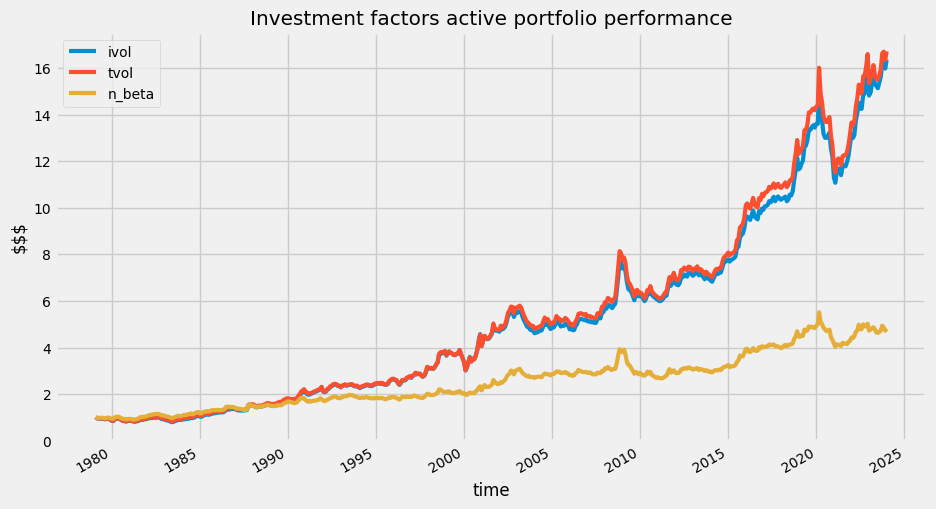

In [86]:
ret_active = pd.DataFrame({'ivol' : ret_ivol_5['Active'],
                           'tvol' : ret_tvol_5['Active'],
                           'n_beta' : ret_nbeta_5['Active']})

ret_active_portfolio = ret_active.cumsum().apply(np.exp)

ret_active_portfolio.plot(figsize=(10, 6),
                          title='Investment factors active portfolio performance',
                          xlabel='time',
                          ylabel='$$$')